In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sn

import matplotlib.pyplot as plt
from IPython.display import Audio, display

import torch
import torch.nn as nn
from torch.nn import init
import torchaudio
import math, random
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.utils.data as data_utils
import torch.nn.functional as F

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
#from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
dataset='C:/Users/Eman Badr/Downloads/data/GroundType1/'

ID=[]
label=[]
ClassID=[]
 
# iterate over files in that directory

for folder in os.listdir(dataset):                               #go into the directory
    for filename in os.listdir(dataset+ str(folder)):          #go in every class 
        f = os.path.join(dataset+ str(folder), filename) #scan through every file in that class
        if os.path.isfile(f):
            ID.append(f.split('\\')[-1])
            label.append(str(folder))
            
for i in range(len(label)):
    if(label[i]=='Concrete'):
        ClassID.append(0) 
    elif(label[i]=='Flatmountain'):
        ClassID.append(1)
    else:
        ClassID.append(2)


In [3]:
dset=pd.DataFrame()
dset['ID']=ID
dset['label']=label
dset['ClassID']=ClassID


In [4]:
dset.head(599)

ID     label  ClassID
0    Concrete-01.wav  Concrete        0
1    Concrete-02.wav  Concrete        0
2    Concrete-03.wav  Concrete        0
3    Concrete-04.wav  Concrete        0
4    Concrete-05.wav  Concrete        0
..               ...       ...      ...
594     Grass-94.wav     Grass        2
595     Grass-95.wav     Grass        2
596     Grass-96.wav     Grass        2
597     Grass-97.wav     Grass        2
598     Grass-98.wav     Grass        2

[599 rows x 3 columns]

In [5]:
dset.to_csv('C:/Users/Eman Badr/Downloads/data/data.csv')

In [6]:
df = pd.read_csv('C:/Users/Eman Badr/Downloads/data/data.csv')

In [7]:
df['ID'].loc[150]

'Concrete-50.wav'

In [8]:
df['ID']

0      Concrete-01.wav
1      Concrete-02.wav
2      Concrete-03.wav
3      Concrete-04.wav
4      Concrete-05.wav
            ...       
595       Grass-95.wav
596       Grass-96.wav
597       Grass-97.wav
598       Grass-98.wav
599       Grass-99.wav
Name: ID, Length: 600, dtype: object

In [9]:
Grass = 'C:/Users/Eman Badr/Downloads/data/GroundType1/Grass/'
path=os.path.join(Grass, df['ID'].loc[595])
print(path)

C:/Users/Eman Badr/Downloads/data/GroundType1/Grass/Grass-95.wav


Shape of waveform: torch.Size([1, 156000])
Sample rate of waveform: 48000
(tensor([[-9.5856e-02, -8.4930e-02, -7.0007e-02,  ...,  6.1035e-05,
          1.3672e-02,  2.6642e-02]]), 48000)


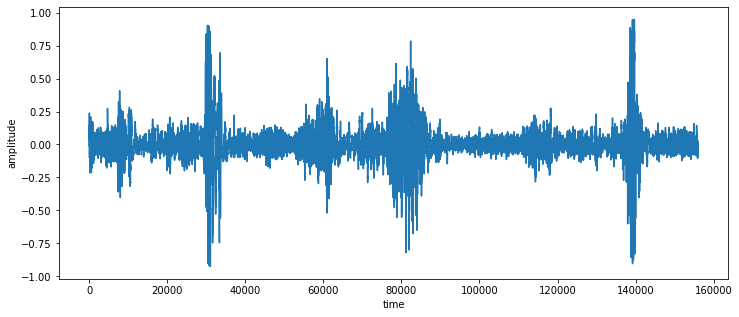

In [10]:
def plot_audio(filename):
    waveform, sample_rate = torchaudio.load(filename)

    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    fig1, ax1 = plt.subplots(figsize=(12, 5))    
  
    ax1.plot(waveform[0,:].numpy())

    ax1.set_xlabel('time') 
    ax1.set_ylabel("amplitude")

    return waveform, sample_rate


aud= plot_audio(path)
print(aud)

Shape of spec: torch.Size([1, 64, 305])
Shape of spec: torch.Size([1, 64, 305])


tensor([[[ 25.5493,  21.3841,  22.3438,  ...,  -3.5486,  12.9258,  15.9601],
         [ 27.8234,  25.0760,  25.8150,  ...,   3.6385,  11.6593,  20.3916],
         [ 24.6822,  27.2284,  24.1783,  ...,  11.5164,  10.3024,  18.8846],
         ...,
         [-31.9133, -36.2757, -35.0923,  ..., -36.1378, -36.3619, -35.0219],
         [-29.8891, -35.5567, -35.3948,  ..., -33.3156, -36.0309, -33.8310],
         [-29.4297, -34.2287, -34.1284,  ..., -34.9304, -34.0786, -34.0415]]])

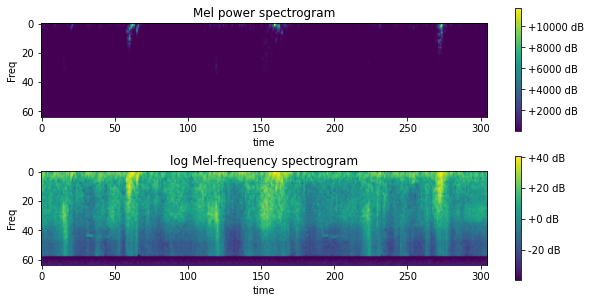

In [11]:
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, sr = aud
    top_db = 80
    
    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec1 = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec1)
    
    
    print("Shape of spec: {}".format(spec1.size()))
    print("Shape of spec: {}".format(spec.size()))
     
    fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True,  figsize=(10, 5))
   
    
    s= ax[0].imshow(spec1[0,:,:].numpy())
    s1= ax[1].imshow(spec[0,:,:].numpy())
    ax[0].grid(False)
    ax[1].grid(False)
    fig.colorbar(s, ax=ax[0], format='%+2.0f dB') 
    fig.colorbar(s1, ax=ax[1], format='%+2.0f dB')    
    ax[0].set_title('Mel power spectrogram') 
    ax[0].set_xlabel('time') 
    ax[0].set_ylabel("Freq")
    
    ax[1].set_title('log Mel-frequency spectrogram')
    ax[1].set_xlabel('time') 
    ax[1].set_ylabel("Freq")


    return (spec)


spectro_gram(aud)

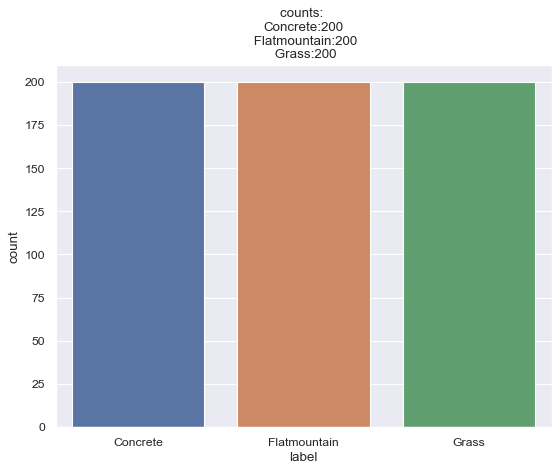

In [12]:
plt.figure(figsize=(8,6),dpi=80)
sn.set_theme(style="darkgrid")
sn.countplot(x ='label',data=dset)
plt.title('counts: \n' +'Concrete:'+str(dset.label.value_counts()[0])+'\n Flatmountain:'+str(dset.label.value_counts()[1])+'\n Grass:'+str(dset.label.value_counts()[2]))
plt.show()

In [13]:
print(dset.label.unique())

['Concrete' 'Flatmountain' 'Grass']


In [14]:
print("Number of training examples=", dset.shape[0], "  Number of classes=", len(dset.label.unique()))

Number of training examples= 600   Number of classes= 3


In [15]:
# Read file

df['ID'] = df['label'].astype(str) + '/' + df['ID'].astype(str)
# Take relevant columns
df = df[['ID', 'ClassID']]
df.head(350)

ID  ClassID
0                  Concrete/Concrete-01.wav        0
1                  Concrete/Concrete-02.wav        0
2                  Concrete/Concrete-03.wav        0
3                  Concrete/Concrete-04.wav        0
4                  Concrete/Concrete-05.wav        0
..                                      ...      ...
345  Flatmountain/Flat mountain road-45.wav        1
346  Flatmountain/Flat mountain road-46.wav        1
347  Flatmountain/Flat mountain road-47.wav        1
348  Flatmountain/Flat mountain road-48.wav        1
349  Flatmountain/Flat mountain road-49.wav        1

[350 rows x 2 columns]

In [16]:
class AudioUtil():
    def open(audio_file): # Load an audio file. Return the signal as a tensor and the sample rate
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    
    def resample(aud, newsr):
        sig, sr = aud
  
        if (sr == newsr):# Nothing to do
            #print('newsr',newsr)
            return aud

        num_channels = sig.shape[0]# Resample first channel
        #print('num_channels',num_channels)
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        #print("Shape of transformed waveform: {}".format(resig.size()))

        #plt.figure()
        #plt.plot(resig[0,:].numpy())
        #print('resig',resig)
        #print('resig',resig.shape)

        return (resig, newsr)
    
    

    def pad_trunc(aud, max_ms):
        sig, sr = aud
        #print('sig',sig)
        #print('sr',sr)
        #print(sig.shape)
        num_rows, sig_len = sig.shape
        #print('num_rows',num_rows)
        #print('sig_len',sig_len)
        max_len = sr//1000 * max_ms
        #print('max_len',max_len)

        if (sig_len > max_len): # Truncate the signal to the given length
           sig = sig[:,:max_len]
           #print('sig_pad_trunc',sig.shape)
           #plt.figure()
           #plt.plot(sig[0,:].numpy())
         

        elif (sig_len < max_len): # Length of padding to add at the beginning and end of the signal
              pad_begin_len = random.randint(0, max_len - sig_len)
              #print('pad_begin_len',pad_begin_len)
              pad_end_len = max_len - sig_len - pad_begin_len
              #print('pad_end_len',pad_end_len)
              # Pad with 0s
              pad_begin = torch.zeros((num_rows, pad_begin_len))
              #print('pad_begin',pad_begin)
              pad_end = torch.zeros((num_rows, pad_end_len))
              sig = torch.cat((pad_begin, sig, pad_end),1) 
              #print('sig_pad_trunc', sig.shape)
              #plt.figure()
              #sig1=sig[0,:].numpy()
              #plt.plot(sig1)      
                                     
        return (sig, sr)          
                                      

    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80
    
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        #print("Shape of spec: {}".format(spec.size()))
        return (spec)
    
        #def play_audio(waveform, sample_rate):
        #display(Audio(waveform[0], rate=sample_rate))
        
        


In [17]:
 #dataset=[]
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 48000
        dataset=[]  
        # ----------------------------
        # Number of items in dataset
        # ----------------------------
    def __len__(self):
        return len(self.df)    
    
       # ----------------------------
       # Get i'th item in dataset
       # ----------------------------
    def __getitem__(self, idx):
       # Absolute file path of the audio file - concatenate the audio directory with the relative path
       audio_file = self.data_path + self.df.loc[idx, 'ID']
       #print(audio_file)

       class_id = self.df.loc[idx, 'ClassID']
        
       ID = self.df.loc[idx, 'ID']

       aud = AudioUtil.open(audio_file)

       reaud = AudioUtil.resample(aud, self.sr)

       dur_aud= AudioUtil.pad_trunc(reaud, self.duration)
       #print(dur_aud)
    
       sgram_features = AudioUtil.spectro_gram(dur_aud)
        
       #listen = AudioUtil.play_audio(dur_aud,self.sr)
       #inputs_m, inputs_s = sgram_features.mean(), sgram_features.std()
       #sgram_features = (sgram_features - inputs_m) / inputs_s


       return  sgram_features,  class_id

In [18]:
myds = SoundDS(df, dataset)

print(myds[20])


(tensor([[[-37.1664, -37.1664, -37.1664,  ..., -37.1664, -37.1664, -37.1664],
         [-37.1664, -37.1664, -37.1664,  ..., -37.1664, -37.1664, -37.1664],
         [-37.1664, -37.1664, -37.1664,  ..., -37.1664, -37.1664, -37.1664],
         ...,
         [-37.1664, -37.1664, -37.1664,  ..., -37.1664, -37.1664, -37.1664],
         [-37.1664, -37.1664, -37.1664,  ..., -37.1664, -37.1664, -37.1664],
         [-37.1664, -37.1664, -37.1664,  ..., -37.1664, -37.1664, -37.1664]]]), 0)


In [19]:
# data loader

random_seed = 64
torch.manual_seed(random_seed)
batch_size = 32

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
len(train_ds), len(val_ds)

# Create training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size= batch_size, shuffle=True)
print(len(train_loader))
test_loader = torch.utils.data.DataLoader(val_ds, batch_size= batch_size, shuffle=False)
print(len(test_loader))
#for i, batch in enumerate(train_loader):
   #print(i, batch)

15
4


In [20]:
examples = iter(train_loader)
data, targets= examples.next()
print(data.shape, targets.shape)
#print(' '.join(f'{classes[targets[j]]:5s}' for j in range(batch_size)))



examples = iter(test_loader)
example_data,example_targets= examples.next()
print(example_data.shape, example_targets.shape)
#print(' '.join(f'{classes[example_targets[j]]:5s}' for j in range(batch_size)))

torch.Size([32, 1, 64, 376]) torch.Size([32])
torch.Size([32, 1, 64, 376]) torch.Size([32])


In [21]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

 
#Define the image classes
classes = ['concrete', 'flat', 'grass']

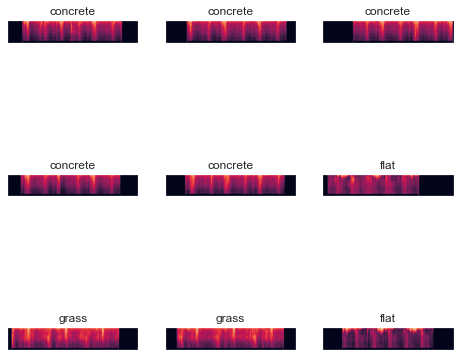

In [22]:
#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [23]:
data2 = data[0].reshape(len(data[0]),-1)

print(data[0].shape)
print(data2)
print(data2.shape)

torch.Size([1, 64, 376])
tensor([[-37.2508, -37.2508, -37.2508,  ..., -37.2508, -37.2508, -37.2508]])
torch.Size([1, 24064])


In [24]:
conv1= nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)
conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=2, padding=(1, 1))
conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=2, padding=0)
pool= nn.BatchNorm2d(16)
x2=nn.BatchNorm2d(16)
x=conv1(example_data)
x1=conv2(x)
x2=pool(x1)
x3=conv3(x2)
print(x.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)

torch.Size([32, 8, 32, 188])
torch.Size([32, 16, 16, 94])
torch.Size([32, 16, 16, 94])
torch.Size([32, 32, 7, 46])


In [25]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim=128,fc2_input_dim=128):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(nn.Linear(46 * 7 * 32, 32),
            nn.ReLU(True),
            nn.Linear(32, 128)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [26]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(True),
            nn.Linear(32, 7 * 46 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 7, 46))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 5, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [27]:
#Loss function
loss_fn =  nn.BCELoss()


### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
#d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=128,fc2_input_dim=128)
#encoder= encoder.numpy()
decoder = Decoder(encoded_space_dim=118,fc2_input_dim=128)
params_to_optimize = [{'params': encoder.parameters()},{'params': decoder.parameters()}]

print(encoder)

#Optimizer
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=10304, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=128, bias=True)
  )
)
Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=10304, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 7, 46))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [28]:
### Training function
def train_epoch(encoder, decoder, device, data2, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in train_loader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
     
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [29]:
### Testing function
def test_epoch(encoder, decoder, device, test_loader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in test_loader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        
    return val_loss


In [30]:
data= train_loader.dataset[89][0]
print(data)

tensor([[[-36.2485, -36.2485, -36.2485,  ..., -36.2485, -36.2485, -36.2485],
         [-36.2485, -36.2485, -36.2485,  ..., -36.2485, -36.2485, -36.2485],
         [-36.2485, -36.2485, -36.2485,  ..., -36.2485, -36.2485, -36.2485],
         ...,
         [-36.2485, -36.2485, -36.2485,  ..., -36.2485, -36.2485, -36.2485],
         [-36.2485, -36.2485, -36.2485,  ..., -36.2485, -36.2485, -36.2485],
         [-36.2485, -36.2485, -36.2485,  ..., -36.2485, -36.2485, -36.2485]]])


In [31]:
data, targets = train_loader.dataset[89]
print(targets)

0


In [32]:
def plot_ae_outputs(encoder,decoder,n=4):
    classes = ['concrete', 'flat', 'grass']
    print("Original Images")
    fig = plt.figure(figsize=(16, 4))
    
    
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img =  test_loader.dataset[i][0].unsqueeze(0).to(device)
      data, targets = train_loader.dataset[i]
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
          rec_img  = decoder(encoder(img))
        
      ax.set_title(classes[targets])
      plt.imshow(img.cpu().squeeze().numpy())
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
    
  
      ax = plt.subplot(2, n, i+1+n)
      plt.imshow(rec_img.cpu().squeeze().numpy())  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
        
      #if i == n//6:
         #ax.set_title('Reconstructed images')
      ax.set_title(classes[targets])
    plt.show()  

	 partial train loss (single batch): 0.770290
	 partial train loss (single batch): 0.247462
	 partial train loss (single batch): -0.400292
	 partial train loss (single batch): -0.776536
	 partial train loss (single batch): -1.285158
	 partial train loss (single batch): -2.143653
	 partial train loss (single batch): -2.844484
	 partial train loss (single batch): -3.166986
	 partial train loss (single batch): -4.352984
	 partial train loss (single batch): -4.661514
	 partial train loss (single batch): -5.704452
	 partial train loss (single batch): -6.212896
	 partial train loss (single batch): -6.953649
	 partial train loss (single batch): -7.813730
	 partial train loss (single batch): -8.479550

 EPOCH 1/40 	 train loss -3.5852086544036865 	 val loss 0.7013123035430908
Original Images


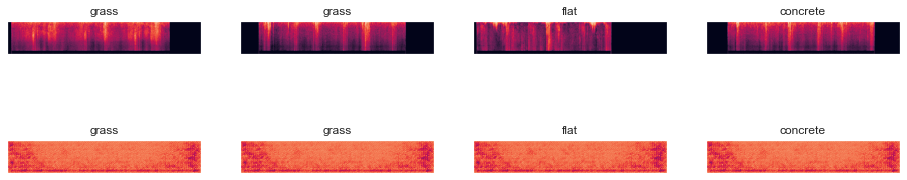

	 partial train loss (single batch): -9.481715
	 partial train loss (single batch): -10.480141
	 partial train loss (single batch): -11.313369
	 partial train loss (single batch): -12.416299
	 partial train loss (single batch): -13.374920
	 partial train loss (single batch): -13.676355
	 partial train loss (single batch): -15.041180
	 partial train loss (single batch): -15.985596
	 partial train loss (single batch): -17.636868
	 partial train loss (single batch): -17.658607
	 partial train loss (single batch): -19.102041
	 partial train loss (single batch): -20.770649
	 partial train loss (single batch): -20.868269
	 partial train loss (single batch): -23.470152
	 partial train loss (single batch): -24.103245

 EPOCH 2/40 	 train loss -16.358627319335938 	 val loss -19.409584045410156
Original Images


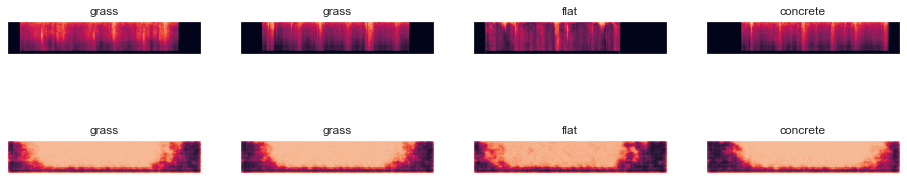

	 partial train loss (single batch): -23.902817
	 partial train loss (single batch): -25.557682
	 partial train loss (single batch): -27.672436
	 partial train loss (single batch): -28.489100
	 partial train loss (single batch): -29.060345
	 partial train loss (single batch): -31.686172
	 partial train loss (single batch): -31.811199
	 partial train loss (single batch): -33.036331
	 partial train loss (single batch): -35.368984
	 partial train loss (single batch): -34.750656
	 partial train loss (single batch): -36.408543
	 partial train loss (single batch): -37.312489
	 partial train loss (single batch): -38.093834
	 partial train loss (single batch): -39.462479
	 partial train loss (single batch): -40.710522

 EPOCH 3/40 	 train loss -32.888240814208984 	 val loss -43.781959533691406
Original Images


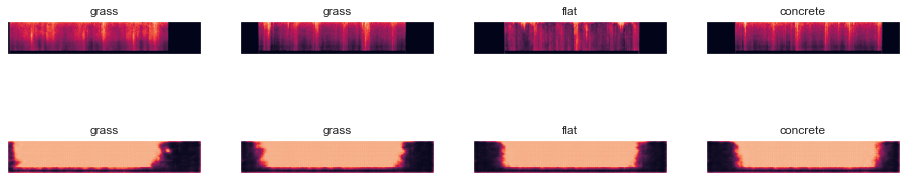

	 partial train loss (single batch): -42.740883
	 partial train loss (single batch): -42.977943
	 partial train loss (single batch): -44.756607
	 partial train loss (single batch): -45.348618
	 partial train loss (single batch): -47.049522
	 partial train loss (single batch): -48.489834
	 partial train loss (single batch): -47.936234
	 partial train loss (single batch): -49.330212
	 partial train loss (single batch): -53.337902
	 partial train loss (single batch): -51.342789
	 partial train loss (single batch): -53.249287
	 partial train loss (single batch): -55.787529
	 partial train loss (single batch): -55.099037
	 partial train loss (single batch): -56.862595
	 partial train loss (single batch): -58.825436

 EPOCH 4/40 	 train loss -50.20896530151367 	 val loss -66.31170654296875
Original Images


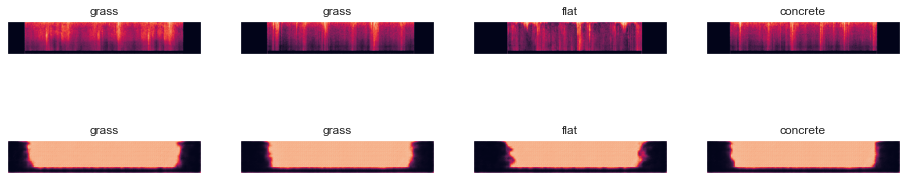

	 partial train loss (single batch): -61.320602
	 partial train loss (single batch): -61.062874
	 partial train loss (single batch): -61.418282
	 partial train loss (single batch): -63.281490
	 partial train loss (single batch): -64.513054
	 partial train loss (single batch): -68.286674
	 partial train loss (single batch): -67.402733
	 partial train loss (single batch): -69.495308
	 partial train loss (single batch): -67.857964
	 partial train loss (single batch): -70.226112
	 partial train loss (single batch): -71.758957
	 partial train loss (single batch): -71.058197
	 partial train loss (single batch): -75.682228
	 partial train loss (single batch): -73.473831
	 partial train loss (single batch): -77.203857

 EPOCH 5/40 	 train loss -68.26948547363281 	 val loss -95.68020629882812
Original Images


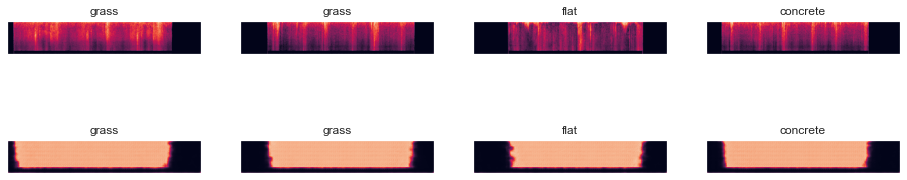

	 partial train loss (single batch): -77.127724
	 partial train loss (single batch): -78.671280
	 partial train loss (single batch): -82.683563
	 partial train loss (single batch): -81.643547
	 partial train loss (single batch): -87.122932
	 partial train loss (single batch): -82.531174
	 partial train loss (single batch): -85.179237
	 partial train loss (single batch): -87.424461
	 partial train loss (single batch): -87.519760
	 partial train loss (single batch): -86.454048
	 partial train loss (single batch): -89.383614
	 partial train loss (single batch): -93.723007
	 partial train loss (single batch): -93.350624
	 partial train loss (single batch): -96.440056
	 partial train loss (single batch): -100.816414

 EPOCH 6/40 	 train loss -87.33809661865234 	 val loss -112.82898712158203
Original Images


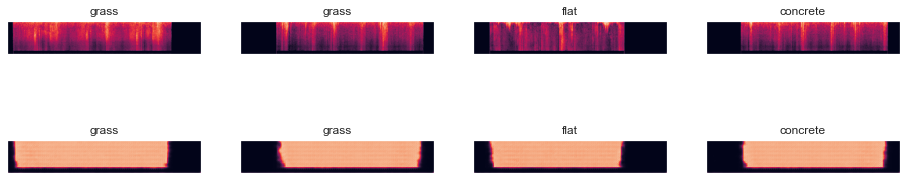

	 partial train loss (single batch): -99.320229
	 partial train loss (single batch): -99.442520
	 partial train loss (single batch): -100.500397
	 partial train loss (single batch): -98.987541
	 partial train loss (single batch): -106.702713
	 partial train loss (single batch): -104.587120
	 partial train loss (single batch): -106.683327
	 partial train loss (single batch): -107.158615
	 partial train loss (single batch): -106.752647
	 partial train loss (single batch): -111.473610
	 partial train loss (single batch): -113.286819
	 partial train loss (single batch): -112.107140
	 partial train loss (single batch): -116.137444
	 partial train loss (single batch): -115.404472
	 partial train loss (single batch): -119.365814

 EPOCH 7/40 	 train loss -107.8606948852539 	 val loss -133.5112762451172
Original Images


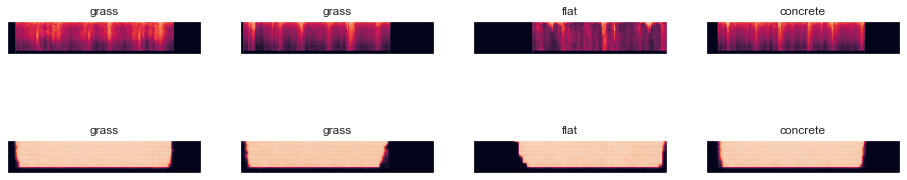

	 partial train loss (single batch): -120.536659
	 partial train loss (single batch): -122.077530
	 partial train loss (single batch): -120.952499
	 partial train loss (single batch): -126.210861
	 partial train loss (single batch): -125.572563
	 partial train loss (single batch): -127.594727
	 partial train loss (single batch): -128.491531
	 partial train loss (single batch): -129.930099
	 partial train loss (single batch): -130.309845
	 partial train loss (single batch): -137.288483
	 partial train loss (single batch): -132.766998
	 partial train loss (single batch): -141.040543
	 partial train loss (single batch): -141.055084
	 partial train loss (single batch): -145.185089
	 partial train loss (single batch): -144.280304

 EPOCH 8/40 	 train loss -131.55284118652344 	 val loss -153.75010681152344
Original Images


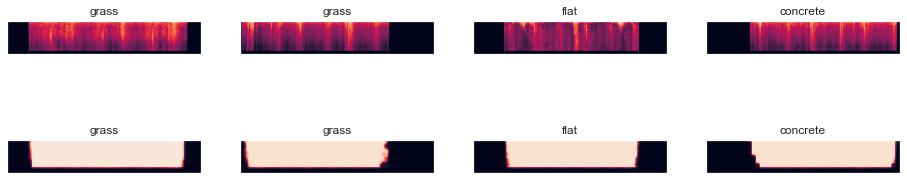

	 partial train loss (single batch): -144.155182
	 partial train loss (single batch): -145.155548
	 partial train loss (single batch): -151.036804
	 partial train loss (single batch): -150.003464
	 partial train loss (single batch): -154.080551
	 partial train loss (single batch): -151.435333
	 partial train loss (single batch): -153.801346
	 partial train loss (single batch): -161.581985
	 partial train loss (single batch): -157.445297
	 partial train loss (single batch): -162.270798
	 partial train loss (single batch): -162.045410
	 partial train loss (single batch): -167.100815
	 partial train loss (single batch): -164.942490
	 partial train loss (single batch): -167.966034
	 partial train loss (single batch): -166.722412

 EPOCH 9/40 	 train loss -157.31622314453125 	 val loss -164.49256896972656
Original Images


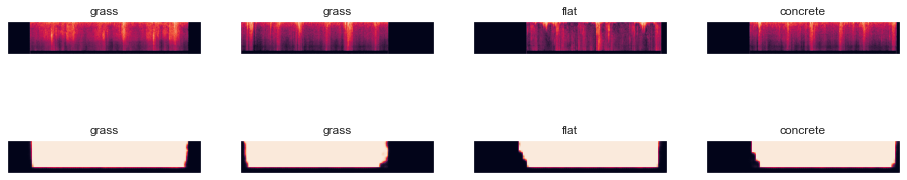

	 partial train loss (single batch): -174.394531
	 partial train loss (single batch): -177.810623
	 partial train loss (single batch): -175.451706
	 partial train loss (single batch): -177.286240
	 partial train loss (single batch): -173.126724
	 partial train loss (single batch): -179.705994
	 partial train loss (single batch): -179.784241
	 partial train loss (single batch): -191.989532
	 partial train loss (single batch): -179.315887
	 partial train loss (single batch): -186.061066
	 partial train loss (single batch): -189.290833
	 partial train loss (single batch): -186.043182
	 partial train loss (single batch): -193.763672
	 partial train loss (single batch): -192.977692
	 partial train loss (single batch): -196.254730

 EPOCH 10/40 	 train loss -183.55044555664062 	 val loss -174.86279296875
Original Images


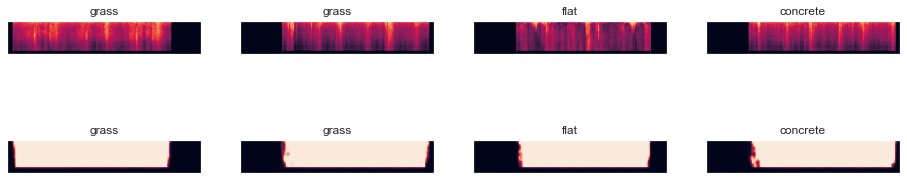

	 partial train loss (single batch): -198.617004
	 partial train loss (single batch): -196.791092
	 partial train loss (single batch): -201.548645
	 partial train loss (single batch): -205.786774
	 partial train loss (single batch): -202.906723
	 partial train loss (single batch): -206.349716
	 partial train loss (single batch): -210.328583
	 partial train loss (single batch): -204.065582
	 partial train loss (single batch): -213.274292
	 partial train loss (single batch): -214.444107
	 partial train loss (single batch): -213.106735
	 partial train loss (single batch): -211.314407
	 partial train loss (single batch): -225.421646
	 partial train loss (single batch): -221.303665
	 partial train loss (single batch): -220.342377

 EPOCH 11/40 	 train loss -209.70675659179688 	 val loss -195.92132568359375
Original Images


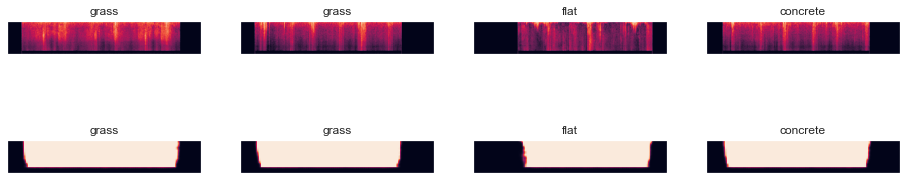

	 partial train loss (single batch): -228.403915
	 partial train loss (single batch): -216.224319
	 partial train loss (single batch): -219.761337
	 partial train loss (single batch): -225.618637
	 partial train loss (single batch): -235.352692
	 partial train loss (single batch): -240.610733
	 partial train loss (single batch): -233.959900
	 partial train loss (single batch): -234.740860
	 partial train loss (single batch): -232.283768
	 partial train loss (single batch): -239.000916
	 partial train loss (single batch): -244.610855
	 partial train loss (single batch): -247.562683
	 partial train loss (single batch): -244.362778
	 partial train loss (single batch): -245.635727
	 partial train loss (single batch): -234.274185

 EPOCH 12/40 	 train loss -234.82688903808594 	 val loss -234.9119415283203
Original Images


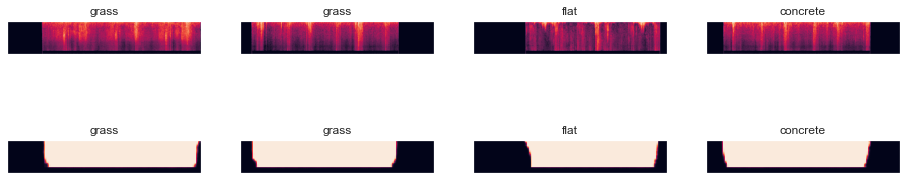

	 partial train loss (single batch): -248.162857
	 partial train loss (single batch): -242.642303
	 partial train loss (single batch): -248.489960
	 partial train loss (single batch): -253.881851
	 partial train loss (single batch): -257.700043
	 partial train loss (single batch): -256.240021
	 partial train loss (single batch): -252.997086
	 partial train loss (single batch): -264.282318
	 partial train loss (single batch): -259.361267
	 partial train loss (single batch): -273.388184
	 partial train loss (single batch): -264.122894
	 partial train loss (single batch): -270.288727
	 partial train loss (single batch): -262.909546
	 partial train loss (single batch): -262.423401
	 partial train loss (single batch): -271.324768

 EPOCH 13/40 	 train loss -259.21435546875 	 val loss -255.6746063232422
Original Images


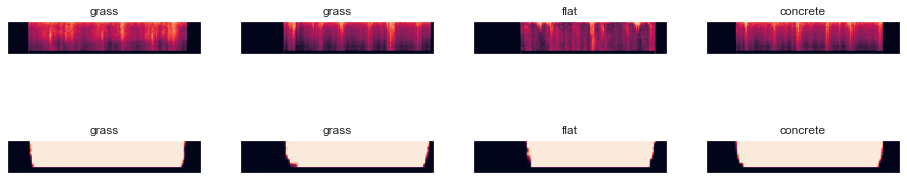

	 partial train loss (single batch): -274.091034
	 partial train loss (single batch): -277.645996
	 partial train loss (single batch): -280.070404
	 partial train loss (single batch): -270.879700
	 partial train loss (single batch): -284.556976
	 partial train loss (single batch): -279.436859
	 partial train loss (single batch): -284.676819
	 partial train loss (single batch): -287.754333
	 partial train loss (single batch): -279.687592
	 partial train loss (single batch): -276.901398
	 partial train loss (single batch): -283.571198
	 partial train loss (single batch): -289.838257
	 partial train loss (single batch): -290.591675
	 partial train loss (single batch): -281.837524
	 partial train loss (single batch): -302.579193

 EPOCH 14/40 	 train loss -282.9412841796875 	 val loss -294.5573425292969
Original Images


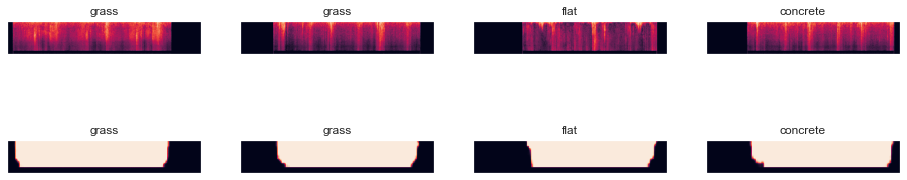

	 partial train loss (single batch): -292.938873
	 partial train loss (single batch): -299.372070
	 partial train loss (single batch): -296.339874
	 partial train loss (single batch): -302.890930
	 partial train loss (single batch): -289.108215
	 partial train loss (single batch): -303.376007
	 partial train loss (single batch): -311.106018
	 partial train loss (single batch): -311.856140
	 partial train loss (single batch): -304.244232
	 partial train loss (single batch): -311.780365
	 partial train loss (single batch): -309.346497
	 partial train loss (single batch): -315.131042
	 partial train loss (single batch): -310.334503
	 partial train loss (single batch): -314.595734
	 partial train loss (single batch): -315.844086

 EPOCH 15/40 	 train loss -305.8843078613281 	 val loss -294.0320129394531
Original Images


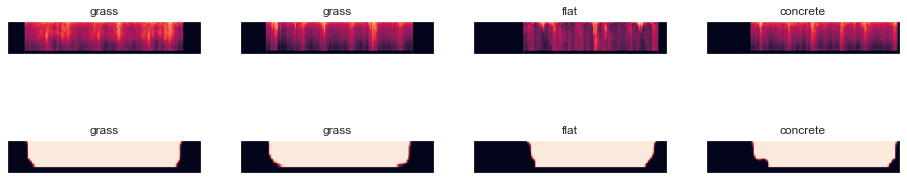

	 partial train loss (single batch): -312.889343
	 partial train loss (single batch): -321.094604
	 partial train loss (single batch): -318.897369
	 partial train loss (single batch): -322.357574
	 partial train loss (single batch): -309.191925
	 partial train loss (single batch): -319.745728
	 partial train loss (single batch): -320.926788
	 partial train loss (single batch): -319.647430
	 partial train loss (single batch): -333.906403
	 partial train loss (single batch): -323.618927
	 partial train loss (single batch): -332.985931
	 partial train loss (single batch): -324.279266
	 partial train loss (single batch): -332.894958
	 partial train loss (single batch): -343.162262
	 partial train loss (single batch): -335.308502

 EPOCH 16/40 	 train loss -324.72711181640625 	 val loss -329.1056213378906
Original Images


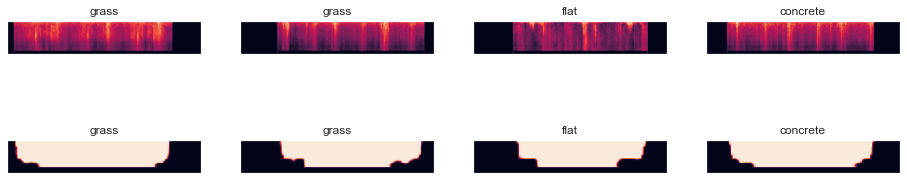

	 partial train loss (single batch): -339.341309
	 partial train loss (single batch): -330.185211
	 partial train loss (single batch): -343.776855
	 partial train loss (single batch): -344.727112
	 partial train loss (single batch): -334.329254
	 partial train loss (single batch): -328.418060
	 partial train loss (single batch): -353.280304
	 partial train loss (single batch): -343.846466
	 partial train loss (single batch): -339.964935
	 partial train loss (single batch): -348.107178
	 partial train loss (single batch): -347.686157
	 partial train loss (single batch): -345.612732
	 partial train loss (single batch): -334.292389
	 partial train loss (single batch): -348.358948
	 partial train loss (single batch): -342.098999

 EPOCH 17/40 	 train loss -341.6017150878906 	 val loss -341.5442810058594
Original Images


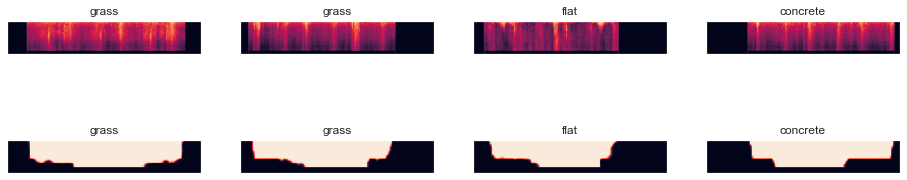

	 partial train loss (single batch): -354.917999
	 partial train loss (single batch): -343.678162
	 partial train loss (single batch): -352.308685
	 partial train loss (single batch): -355.073029
	 partial train loss (single batch): -351.843414
	 partial train loss (single batch): -356.492340
	 partial train loss (single batch): -366.496582
	 partial train loss (single batch): -356.442535
	 partial train loss (single batch): -357.809723
	 partial train loss (single batch): -353.785767
	 partial train loss (single batch): -358.893921
	 partial train loss (single batch): -364.511963
	 partial train loss (single batch): -361.521484
	 partial train loss (single batch): -370.157074
	 partial train loss (single batch): -368.741852

 EPOCH 18/40 	 train loss -358.1783447265625 	 val loss -349.45025634765625
Original Images


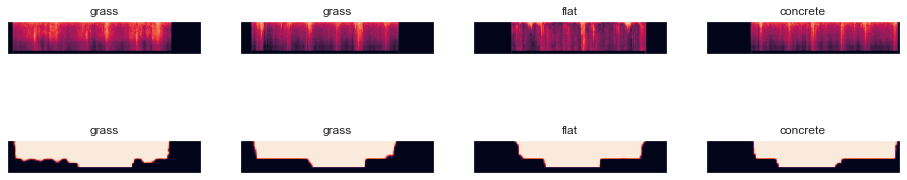

	 partial train loss (single batch): -366.932220
	 partial train loss (single batch): -372.676392
	 partial train loss (single batch): -362.644440
	 partial train loss (single batch): -367.349731
	 partial train loss (single batch): -377.511627
	 partial train loss (single batch): -370.592590
	 partial train loss (single batch): -373.385315
	 partial train loss (single batch): -385.888367
	 partial train loss (single batch): -371.192566
	 partial train loss (single batch): -374.160645
	 partial train loss (single batch): -382.351074
	 partial train loss (single batch): -383.681854
	 partial train loss (single batch): -362.474152
	 partial train loss (single batch): -381.678680
	 partial train loss (single batch): -376.431946

 EPOCH 19/40 	 train loss -373.93011474609375 	 val loss -354.36407470703125
Original Images


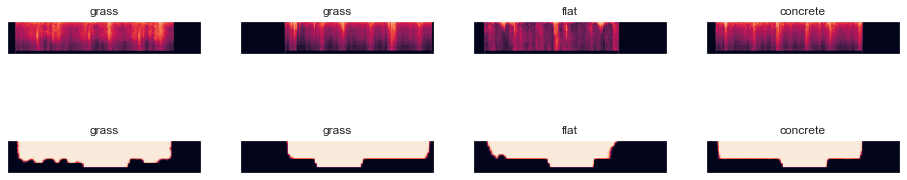

	 partial train loss (single batch): -393.859131
	 partial train loss (single batch): -380.904510
	 partial train loss (single batch): -376.532166
	 partial train loss (single batch): -391.801208
	 partial train loss (single batch): -389.288574
	 partial train loss (single batch): -380.279602
	 partial train loss (single batch): -382.854889
	 partial train loss (single batch): -389.085114
	 partial train loss (single batch): -397.589813
	 partial train loss (single batch): -383.092163
	 partial train loss (single batch): -386.614349
	 partial train loss (single batch): -389.435852
	 partial train loss (single batch): -399.559021
	 partial train loss (single batch): -399.547943
	 partial train loss (single batch): -406.706604

 EPOCH 20/40 	 train loss -389.81005859375 	 val loss -372.1595764160156
Original Images


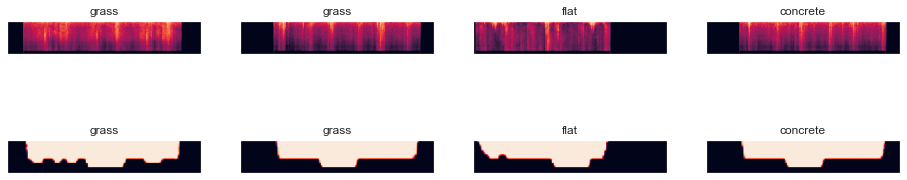

	 partial train loss (single batch): -399.698669
	 partial train loss (single batch): -395.074097
	 partial train loss (single batch): -412.317230
	 partial train loss (single batch): -394.289215
	 partial train loss (single batch): -395.109711
	 partial train loss (single batch): -417.624908
	 partial train loss (single batch): -400.530487
	 partial train loss (single batch): -403.639587
	 partial train loss (single batch): -406.730225
	 partial train loss (single batch): -405.478149
	 partial train loss (single batch): -410.242889
	 partial train loss (single batch): -410.108185
	 partial train loss (single batch): -403.063049
	 partial train loss (single batch): -397.459412
	 partial train loss (single batch): -414.847961

 EPOCH 21/40 	 train loss -404.41424560546875 	 val loss -369.70849609375
Original Images


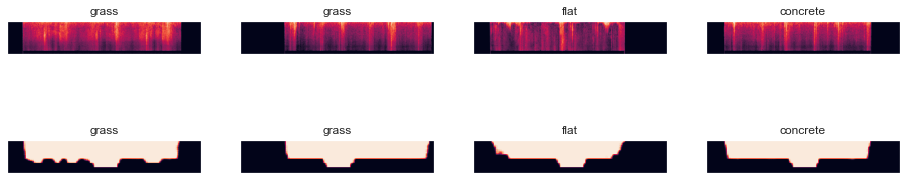

	 partial train loss (single batch): -398.762970
	 partial train loss (single batch): -424.014008
	 partial train loss (single batch): -407.968079
	 partial train loss (single batch): -401.751038
	 partial train loss (single batch): -407.792358
	 partial train loss (single batch): -413.076172
	 partial train loss (single batch): -413.818848
	 partial train loss (single batch): -424.515747
	 partial train loss (single batch): -430.839844
	 partial train loss (single batch): -415.013824
	 partial train loss (single batch): -410.570862
	 partial train loss (single batch): -426.070312
	 partial train loss (single batch): -425.786285
	 partial train loss (single batch): -423.046265
	 partial train loss (single batch): -436.336487

 EPOCH 22/40 	 train loss -417.2908630371094 	 val loss -396.7772521972656
Original Images


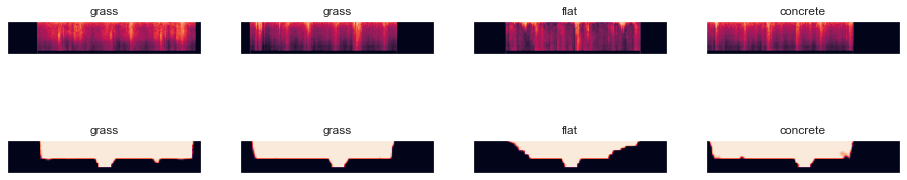

	 partial train loss (single batch): -427.923157
	 partial train loss (single batch): -428.230103
	 partial train loss (single batch): -440.472900
	 partial train loss (single batch): -429.576294
	 partial train loss (single batch): -426.284851
	 partial train loss (single batch): -440.852386
	 partial train loss (single batch): -427.983704
	 partial train loss (single batch): -429.998596
	 partial train loss (single batch): -423.881073
	 partial train loss (single batch): -419.235565
	 partial train loss (single batch): -431.681976
	 partial train loss (single batch): -440.894440
	 partial train loss (single batch): -427.163574
	 partial train loss (single batch): -433.192230
	 partial train loss (single batch): -430.619354

 EPOCH 23/40 	 train loss -430.5326843261719 	 val loss -416.2673645019531
Original Images


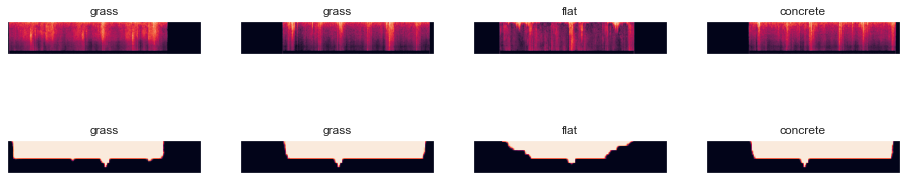

	 partial train loss (single batch): -422.202820
	 partial train loss (single batch): -436.784790
	 partial train loss (single batch): -434.469910
	 partial train loss (single batch): -437.751953
	 partial train loss (single batch): -432.934357
	 partial train loss (single batch): -440.482574
	 partial train loss (single batch): -432.364807
	 partial train loss (single batch): -456.901062
	 partial train loss (single batch): -446.265533
	 partial train loss (single batch): -450.310913
	 partial train loss (single batch): -458.517029
	 partial train loss (single batch): -454.493347
	 partial train loss (single batch): -438.077911
	 partial train loss (single batch): -449.086029
	 partial train loss (single batch): -450.291901

 EPOCH 24/40 	 train loss -442.72900390625 	 val loss -427.8906555175781
Original Images


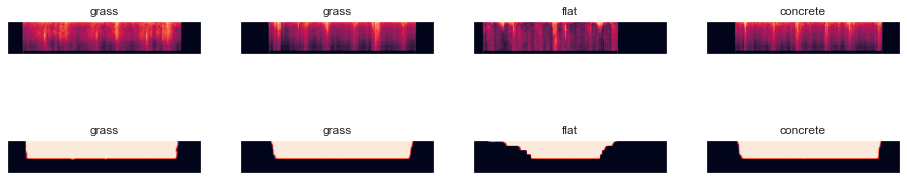

	 partial train loss (single batch): -444.114197
	 partial train loss (single batch): -455.867401
	 partial train loss (single batch): -458.712128
	 partial train loss (single batch): -455.106537
	 partial train loss (single batch): -455.759796
	 partial train loss (single batch): -452.887177
	 partial train loss (single batch): -454.675629
	 partial train loss (single batch): -453.898560
	 partial train loss (single batch): -453.368927
	 partial train loss (single batch): -452.477936
	 partial train loss (single batch): -459.949249
	 partial train loss (single batch): -467.201599
	 partial train loss (single batch): -445.716217
	 partial train loss (single batch): -478.823883
	 partial train loss (single batch): -461.003815

 EPOCH 25/40 	 train loss -456.6375427246094 	 val loss -449.3697814941406
Original Images


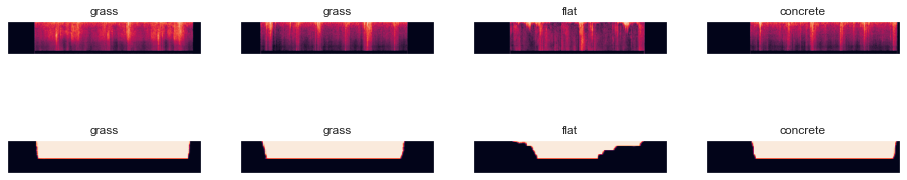

	 partial train loss (single batch): -478.998383
	 partial train loss (single batch): -453.466034
	 partial train loss (single batch): -460.066071
	 partial train loss (single batch): -464.737701
	 partial train loss (single batch): -472.838776
	 partial train loss (single batch): -477.172455
	 partial train loss (single batch): -454.914368
	 partial train loss (single batch): -469.701416
	 partial train loss (single batch): -476.814911
	 partial train loss (single batch): -480.604645
	 partial train loss (single batch): -468.148468
	 partial train loss (single batch): -471.058167
	 partial train loss (single batch): -476.740601
	 partial train loss (single batch): -474.162598
	 partial train loss (single batch): -467.177521

 EPOCH 26/40 	 train loss -469.7734680175781 	 val loss -467.40789794921875
Original Images


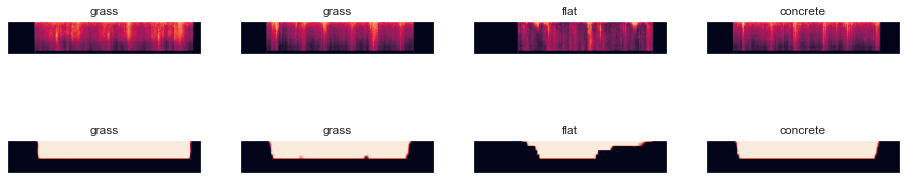

	 partial train loss (single batch): -477.033173
	 partial train loss (single batch): -473.079193
	 partial train loss (single batch): -478.768951
	 partial train loss (single batch): -477.767151
	 partial train loss (single batch): -485.900818
	 partial train loss (single batch): -483.622253
	 partial train loss (single batch): -494.569763
	 partial train loss (single batch): -481.608429
	 partial train loss (single batch): -480.562927
	 partial train loss (single batch): -485.740936
	 partial train loss (single batch): -481.081604
	 partial train loss (single batch): -493.568207
	 partial train loss (single batch): -494.337402
	 partial train loss (single batch): -472.760071
	 partial train loss (single batch): -482.673248

 EPOCH 27/40 	 train loss -482.8716125488281 	 val loss -477.88323974609375
Original Images


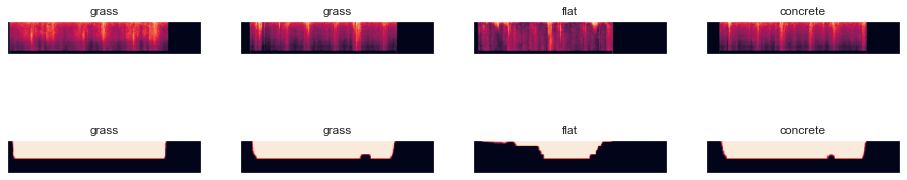

	 partial train loss (single batch): -490.781036
	 partial train loss (single batch): -474.617889
	 partial train loss (single batch): -482.521393
	 partial train loss (single batch): -490.542755
	 partial train loss (single batch): -496.256287
	 partial train loss (single batch): -489.944550
	 partial train loss (single batch): -494.768524
	 partial train loss (single batch): -498.546661
	 partial train loss (single batch): -498.881317
	 partial train loss (single batch): -499.921112
	 partial train loss (single batch): -497.279999
	 partial train loss (single batch): -502.228424
	 partial train loss (single batch): -505.365906
	 partial train loss (single batch): -500.975403
	 partial train loss (single batch): -510.556213

 EPOCH 28/40 	 train loss -495.5458068847656 	 val loss -490.9228820800781
Original Images


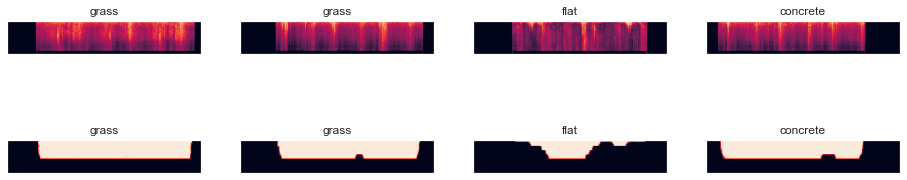

	 partial train loss (single batch): -501.068787
	 partial train loss (single batch): -513.152344
	 partial train loss (single batch): -509.421631
	 partial train loss (single batch): -503.336182
	 partial train loss (single batch): -501.616364
	 partial train loss (single batch): -499.162079
	 partial train loss (single batch): -509.013672
	 partial train loss (single batch): -501.972778
	 partial train loss (single batch): -490.910400
	 partial train loss (single batch): -518.424500
	 partial train loss (single batch): -514.071533
	 partial train loss (single batch): -499.684265
	 partial train loss (single batch): -511.146118
	 partial train loss (single batch): -504.755066
	 partial train loss (single batch): -507.620728

 EPOCH 29/40 	 train loss -505.6903991699219 	 val loss -517.5624389648438
Original Images


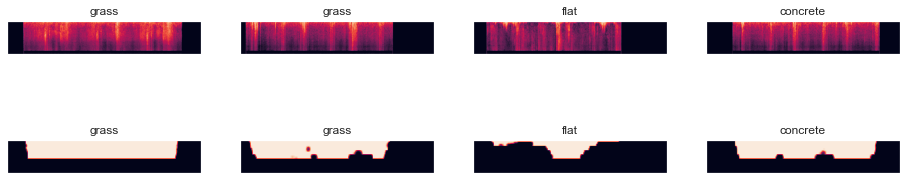

	 partial train loss (single batch): -522.008484
	 partial train loss (single batch): -511.268829
	 partial train loss (single batch): -507.588684
	 partial train loss (single batch): -513.507996
	 partial train loss (single batch): -521.695129
	 partial train loss (single batch): -523.759399
	 partial train loss (single batch): -513.061401
	 partial train loss (single batch): -527.421021
	 partial train loss (single batch): -508.265533
	 partial train loss (single batch): -524.206604
	 partial train loss (single batch): -519.987976
	 partial train loss (single batch): -532.014526
	 partial train loss (single batch): -517.314758
	 partial train loss (single batch): -503.985626
	 partial train loss (single batch): -514.631226

 EPOCH 30/40 	 train loss -517.3811645507812 	 val loss -518.4948120117188
Original Images


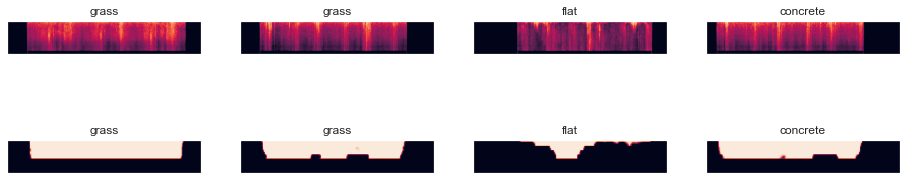

	 partial train loss (single batch): -506.120636
	 partial train loss (single batch): -523.815063
	 partial train loss (single batch): -524.088074
	 partial train loss (single batch): -529.325684
	 partial train loss (single batch): -522.242126
	 partial train loss (single batch): -525.601318
	 partial train loss (single batch): -512.057983
	 partial train loss (single batch): -539.663208
	 partial train loss (single batch): -537.125549
	 partial train loss (single batch): -522.176392
	 partial train loss (single batch): -533.199524
	 partial train loss (single batch): -528.064026
	 partial train loss (single batch): -537.549683
	 partial train loss (single batch): -531.521729
	 partial train loss (single batch): -519.464905

 EPOCH 31/40 	 train loss -526.1343994140625 	 val loss -527.4928588867188
Original Images


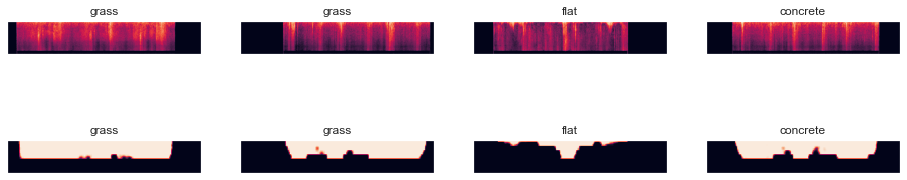

	 partial train loss (single batch): -530.929993
	 partial train loss (single batch): -527.605652
	 partial train loss (single batch): -537.796936
	 partial train loss (single batch): -527.528625
	 partial train loss (single batch): -535.579041
	 partial train loss (single batch): -538.493652
	 partial train loss (single batch): -535.900574
	 partial train loss (single batch): -535.919983
	 partial train loss (single batch): -536.008911
	 partial train loss (single batch): -532.211121
	 partial train loss (single batch): -533.694153
	 partial train loss (single batch): -540.500732
	 partial train loss (single batch): -530.248291
	 partial train loss (single batch): -533.069214
	 partial train loss (single batch): -552.136780

 EPOCH 32/40 	 train loss -535.1749267578125 	 val loss -532.5736083984375
Original Images


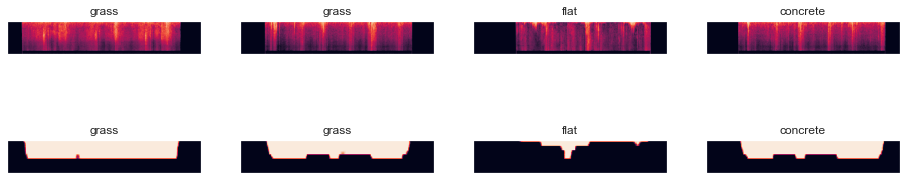

	 partial train loss (single batch): -547.686890
	 partial train loss (single batch): -549.274414
	 partial train loss (single batch): -533.576294
	 partial train loss (single batch): -526.070251
	 partial train loss (single batch): -549.620239
	 partial train loss (single batch): -538.839233
	 partial train loss (single batch): -544.340454
	 partial train loss (single batch): -536.187317
	 partial train loss (single batch): -542.237305
	 partial train loss (single batch): -534.205139
	 partial train loss (single batch): -535.277588
	 partial train loss (single batch): -548.884644
	 partial train loss (single batch): -537.990784
	 partial train loss (single batch): -547.048950
	 partial train loss (single batch): -544.563354

 EPOCH 33/40 	 train loss -541.0535278320312 	 val loss -540.1624755859375
Original Images


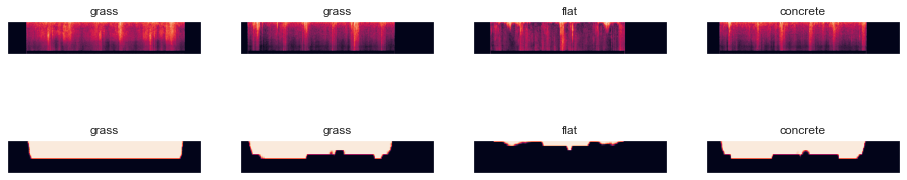

	 partial train loss (single batch): -539.848389
	 partial train loss (single batch): -553.218018
	 partial train loss (single batch): -528.474915
	 partial train loss (single batch): -549.003845
	 partial train loss (single batch): -531.658020
	 partial train loss (single batch): -537.078857
	 partial train loss (single batch): -547.915283
	 partial train loss (single batch): -551.176758
	 partial train loss (single batch): -549.594604
	 partial train loss (single batch): -547.345276
	 partial train loss (single batch): -556.273254
	 partial train loss (single batch): -539.046021
	 partial train loss (single batch): -548.620667
	 partial train loss (single batch): -556.003662
	 partial train loss (single batch): -562.961182

 EPOCH 34/40 	 train loss -546.5479125976562 	 val loss -541.0050659179688
Original Images


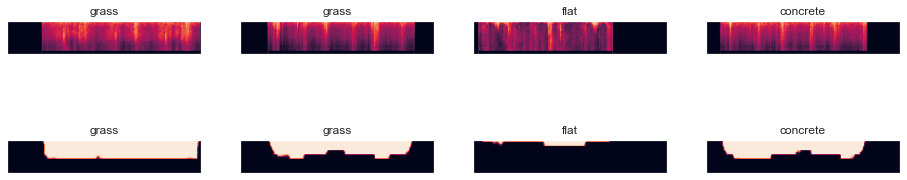

	 partial train loss (single batch): -564.945740
	 partial train loss (single batch): -559.822815
	 partial train loss (single batch): -542.442383
	 partial train loss (single batch): -549.036255
	 partial train loss (single batch): -553.494446
	 partial train loss (single batch): -563.560913
	 partial train loss (single batch): -535.281921
	 partial train loss (single batch): -537.682251
	 partial train loss (single batch): -557.796021
	 partial train loss (single batch): -555.257629
	 partial train loss (single batch): -554.641235
	 partial train loss (single batch): -554.096375
	 partial train loss (single batch): -564.947327
	 partial train loss (single batch): -553.719421
	 partial train loss (single batch): -551.252136

 EPOCH 35/40 	 train loss -553.1984252929688 	 val loss -551.1159057617188
Original Images


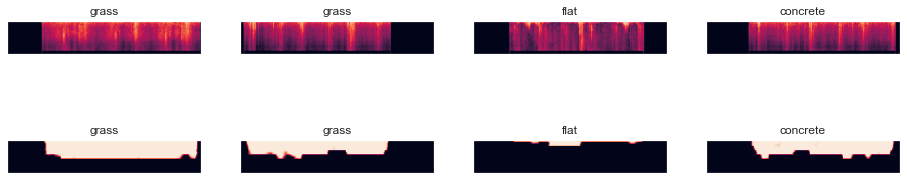

	 partial train loss (single batch): -543.642517
	 partial train loss (single batch): -547.624390
	 partial train loss (single batch): -549.850647
	 partial train loss (single batch): -560.839844
	 partial train loss (single batch): -550.406921
	 partial train loss (single batch): -551.741272
	 partial train loss (single batch): -557.364258
	 partial train loss (single batch): -547.169434
	 partial train loss (single batch): -568.365967
	 partial train loss (single batch): -558.621338
	 partial train loss (single batch): -558.834045
	 partial train loss (single batch): -557.064819
	 partial train loss (single batch): -555.099304
	 partial train loss (single batch): -562.314148
	 partial train loss (single batch): -562.595093

 EPOCH 36/40 	 train loss -555.435546875 	 val loss -543.9285278320312
Original Images


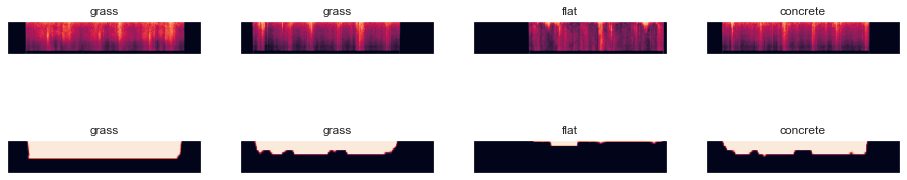

	 partial train loss (single batch): -566.847656
	 partial train loss (single batch): -563.802917
	 partial train loss (single batch): -574.142700
	 partial train loss (single batch): -533.440430
	 partial train loss (single batch): -569.737427
	 partial train loss (single batch): -525.781494
	 partial train loss (single batch): -553.213562
	 partial train loss (single batch): -565.135681
	 partial train loss (single batch): -569.250305
	 partial train loss (single batch): -567.612793
	 partial train loss (single batch): -558.165955
	 partial train loss (single batch): -564.320740
	 partial train loss (single batch): -572.297363
	 partial train loss (single batch): -553.749084
	 partial train loss (single batch): -559.103821

 EPOCH 37/40 	 train loss -559.7734985351562 	 val loss -558.7265014648438
Original Images


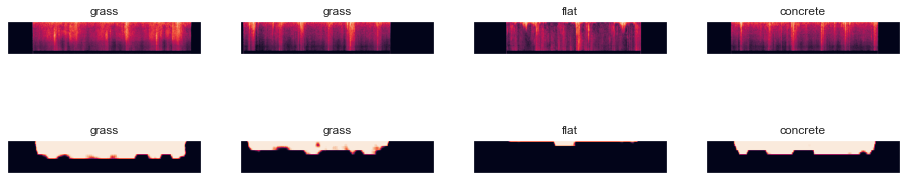

	 partial train loss (single batch): -571.582031
	 partial train loss (single batch): -555.145447
	 partial train loss (single batch): -563.027649
	 partial train loss (single batch): -571.605408
	 partial train loss (single batch): -553.018860
	 partial train loss (single batch): -580.676758
	 partial train loss (single batch): -579.442932
	 partial train loss (single batch): -561.876953
	 partial train loss (single batch): -572.838684
	 partial train loss (single batch): -564.560486
	 partial train loss (single batch): -555.734131
	 partial train loss (single batch): -564.999146
	 partial train loss (single batch): -549.372070
	 partial train loss (single batch): -558.552063
	 partial train loss (single batch): -546.798401

 EPOCH 38/40 	 train loss -563.2821044921875 	 val loss -553.7223510742188
Original Images


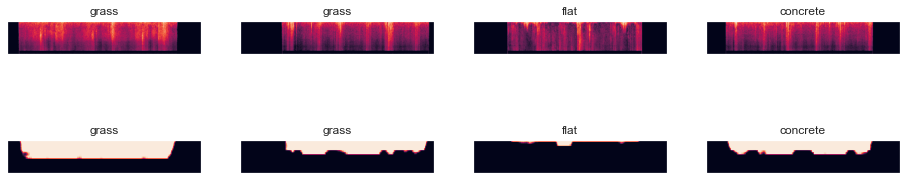

	 partial train loss (single batch): -564.797668
	 partial train loss (single batch): -574.396667
	 partial train loss (single batch): -560.419861
	 partial train loss (single batch): -576.371277
	 partial train loss (single batch): -562.513672
	 partial train loss (single batch): -536.910461
	 partial train loss (single batch): -561.205505
	 partial train loss (single batch): -576.748901
	 partial train loss (single batch): -575.505920
	 partial train loss (single batch): -575.410217
	 partial train loss (single batch): -583.664001
	 partial train loss (single batch): -557.901611
	 partial train loss (single batch): -556.571472
	 partial train loss (single batch): -562.055298
	 partial train loss (single batch): -569.782410

 EPOCH 39/40 	 train loss -566.2836303710938 	 val loss -560.2454833984375
Original Images


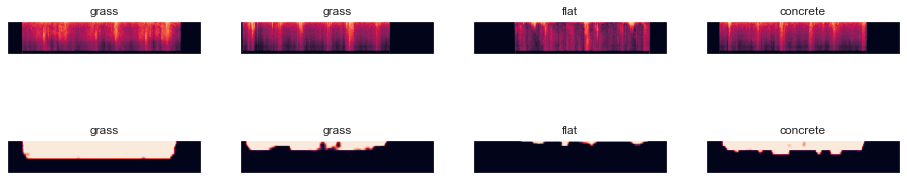

	 partial train loss (single batch): -577.647278
	 partial train loss (single batch): -575.378601
	 partial train loss (single batch): -557.982605
	 partial train loss (single batch): -576.959839
	 partial train loss (single batch): -569.815430
	 partial train loss (single batch): -553.229126
	 partial train loss (single batch): -573.003601
	 partial train loss (single batch): -567.692627
	 partial train loss (single batch): -573.568176
	 partial train loss (single batch): -569.820618
	 partial train loss (single batch): -558.371155
	 partial train loss (single batch): -595.785156
	 partial train loss (single batch): -561.255920
	 partial train loss (single batch): -571.398132
	 partial train loss (single batch): -558.846375

 EPOCH 40/40 	 train loss -569.3836669921875 	 val loss -565.1492309570312
Original Images


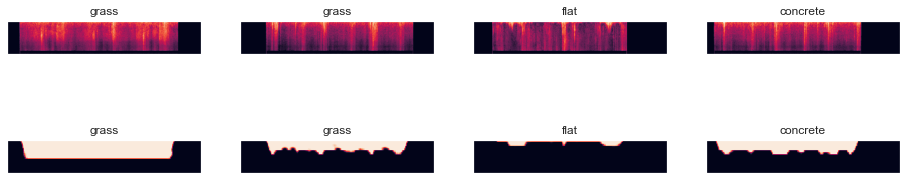

In [33]:
num_epochs = 40
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=4)

In [34]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

-564.9144287109375

In [35]:
from tqdm import tqdm

encoded_samples = []


for sample in tqdm (val_ds):
    
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)

encoded_samples

#list(encoded_samples.values[0])


100%|██████████| 120/120 [00:00<00:00, 185.89it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           5.700173        -4.774384        -1.984383        -3.174002   
1           7.078370        -4.438703         0.274096        -4.526356   
2          -0.313544         2.200657         0.853677        -0.528666   
3           7.577030        -4.585702        -0.637979        -4.064861   
4           2.856270        -0.527974         2.591044        -2.822525   
..               ...              ...              ...              ...   
115         1.044679         0.404129        -0.904602        -1.480555   
116         5.519674        -6.048815        -2.106949        -2.015406   
117         2.313763        -5.202130        -1.290121        -1.691263   
118         4.610923        -0.299064         1.368261        -4.329374   
119         7.571097        -5.055645        -0.384690        -3.680217   

     Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0          -0.403928        -2.104468        -4.167843        -1.643781   
1           0.110179        -2.144048        -1.147189         0.433071   
2           5.563521        -0.038563        -0.389821         1.963715   
3          -0.599197         0.902573        -1.629964         1.329703   
4           3.782863         1.368652        -0.110677         2.703702   
..               ...              ...              ...              ...   
115         4.379562        -2.945051        -0.008916         2.679832   
116         0.550544        -0.445483        -5.902112        -2.027244   
117         4.013652        -2.539932        -5.172465        -0.468071   
118         3.040503         0.838133         1.199183         3.310605   
119        -0.407391         1.998766        -2.235407         1.267337   

     Enc. Variable 8  Enc. Variable 9  ...  Enc. Variable 119  \
0          -0.360472        -6.429412  ...           3.402167   
1          -1.814008        -3.849083  ...           1.317806   
2           1.998320         1.519646  ...          -3.667490   
3          -1.448732        -4.388828  ...           3.598436   
4          -1.299256         0.451239  ...          -2.878539   
..               ...              ...  ...                ...   
115         2.629247        -1.552583  ...          -1.429967   
116         0.119507        -6.466218  ...           2.756058   
117         0.607321        -4.007596  ...          -2.065899   
118        -1.408554        -0.151875  ...          -0.510927   
119        -1.395920        -4.263763  ...           3.351144   

     Enc. Variable 120  Enc. Variable 121  Enc. Variable 122  \
0             1.370537           4.777169          -0.163054   
1             1.278872           3.906099          -0.520809   
2            -1.612063          -3.131500          -4.788155   
3             2.311921           2.850453           0.007980   
4             1.646237          -2.504042          -4.407544   
..                 ...                ...                ...   
115           2.696340          -2.477032          -1.424637   
116           0.625976           3.651127          -0.264821   
117           2.977525          -1.565775          -0.465334   
118           0.246266          -0.474129          -2.962617   
119           2.288222           2.104687           0.063301   

     Enc. Variable 123  Enc. Variable 124  Enc. Variable 125  \
0             1.209061           2.368026          -0.330674   
1            -0.784987           0.975723           0.815896   
2            -0.293115          -1.778090          -1.787082   
3            -2.628574           0.840573          -0.610268   
4            -1.389512          -3.296924          -1.971864   
..                 ...                ...                ...   
115           0.991838           0.667869           0.314114   
116           1.190927           2.355573          -1.335874   
117           2.556166           2.124424          -0.129635   
118          

In [36]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [37]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

C:\Users\Eman Badr\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\Eman Badr\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

